# Zero to Hero

### Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [ ]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   Bajar el  **competencia_01_crudo**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [ ]:
%%shell

mkdir -p "/content/.drive/My Drive/dmeyf"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/dmeyf" /content/buckets/b1


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/competencia_01_crudo.csv"
archivo_destino="/content/datasets/competencia_01_crudo.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/competencia_01_crudo.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


## Generacion de la clase_ternaria

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

In [ ]:
require( "data.table" )

# leo el dataset
dataset <- fread("/content/datasets/competencia_01_crudo.csv" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]


# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

fwrite( dataset,
    file =  "/content/datasets/competencia_01.csv.gz",
    sep = ","
)

In [ ]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

# 1 Arranque rápido

En el capítulo 1 se hará un recorrido por las principales componentes del lenguaje R mínimos necesarios para resolver el problema de la asignatura, justificando las elecciones tomadas.
<br>
No es la idea de estos notebooks ser un manual del lenguaje R ni tampoco de los paquetes.

## 1.01  Lectura del dataset

Trata sobre la motivacion de utilizar  data.table

Trata sobre la motivacion de utilizar data.table Simplemente se carga el dataset y se mide el tiempo que demora, el que es extremadamente alto e inexplicable.

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory


Ahora vamos a cargar el dataframe como en R Base, tradicional, pero vamos a medir el tiempo
para conocer la hora actual utilizo la fucion de R  Sys.time
y para calcular la diferencia utilizo as.numeric(  t1 - t0, units = "secs")  convirtiéndolo a segundos

Primero veo que hace la funcion  Sys.time()

In [ ]:
Sys.time()


devuelve fecha, hora  y huso horario  ( -03 para el caso de Argentina)
<br>
Leyendo la documentación  en  https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/Sys.time    veo que la precisión es de 1/60 segundos,  lo cual para el tipo de medidas que tomaremos es más que suficiente.

In [ ]:
t0 <- Sys.time()
dataset <- read.csv("/content/datasets/competencia_01.csv.gz")
t1 <- Sys.time()
delta <- as.numeric(t1 - t0, units = "secs") # calculo la diferencia de tiempos
print(delta) # imprimo


#### la primer corrida da, 92 segundos !
¿Qué tenebrosos cálculos estará haciendo para demorar 92 segundos?
A lo sumo tiene que leer el archivo dos veces, para determinar si un campo es numerico o character.

vuelvo a correr lo mismo, quizas hubo un problema de acceso al disco, y hasta quizas esta segunda vez el archivo ya esté en la memoria del sistema operativo

In [ ]:
t0 <- Sys.time()
dataset <- read.csv("/content/datasets/competencia_01.csv.gz")
t1 <- Sys.time()
delta <- as.numeric(t1 - t0, units = "secs") # calculo la diferencia de tiempos
print(delta) # imprimo


### la segunda corrida da  81 segundos !

Se busca bibliografía sobre que alternativa hay al manejo de dataframes del R Base
<br>
Aparecen varias alternativas, benchmarks muestran la superioridad de data.table
<br>
Pasamos a probar la libreria  data.table a ver si los becnmarks están en lo cierto, o es solo marketing
<br>
Si no se tiene instalada la libreria,  instalarla primero con  **install.packages( "data.table", dependencies=TRUE )**

In [ ]:
library("data.table") # cargo la libreria  data.table

if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

In [ ]:
t0 <- Sys.time()
dataset <- fread("/content/datasets/competencia_01.csv.gz")
t1 <- Sys.time()
delta <- as.numeric(t1 - t0, units = "secs") # calculo la diferencia de tiempos
print(delta) # imprimo


###### la primer corrida da  17 segundos

Hagamos una segunda corrida

In [ ]:
t0 <- Sys.time()
dataset <- fread("/content/datasets/competencia_01.csv.gz")
t1 <- Sys.time()
delta <- as.numeric(t1 - t0, units = "secs") # calculo la diferencia de tiempos
print(delta) # imprimo


# la segunda corrida da  13 segundos

Ciertamente leer un dataset es una tarea que se hace unicamente al comienzo de los programas, pero se lee en la bibligrafía que data.table funciona más rápido para *todas* las operaciones sobre datasets, lo que se confirmará en los siguientes capítulos.

Es una verdadera pena que los fans de tidyverse no exploren data.table, así como en Python que Pandas sea tan servilmente aceptada.



---



\## 1.02  Operaciones básicas

Se muestra una alternativa a cargar el dataset directamente desde la nube, que funciona desde Kaggle, Google Colab
<br>
Si se está corriendo desde la PC local, siempre es preferible cargar el archivo del disco local.

limpio el ambiente de R

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table

if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz")


### Ahora, algunas operaciones básicas con el dataset

cantidad de registros y columnas

In [ ]:
nrow(dataset)
ncol(dataset)


Otra forma de ver la cantidad de registros del dataset, al  *estilo data table*
<br>
El .N  es la cantidad de registros y va en la segunda poscion  dataset[ 1, 2, 3 ]

In [ ]:
dataset[, .N]


Ahora hacemos la apertura por el periodo, el campo  foto_mes

In [ ]:
dataset[, .N, foto_mes]


nombre de las columnas del dataset

In [ ]:
colnames(dataset)


Exploración de clase_ternaria.

In [ ]:
dataset[, .N, list(foto_mes, clase_ternaria)]


###  varias formas de contar los BAJA+2

todas las formas dan el mismo resultado

In [ ]:
nrow(dataset[clase_ternaria == "BAJA+2"])


In [ ]:
dataset[clase_ternaria == "BAJA+2", .N] # el autentico estilo data.table


In [ ]:
dataset[, sum(clase_ternaria == "BAJA+2")]


### Conteo de proporcion de BAJA+2 en el dataset

In [ ]:
dataset[foto_mes == 202104, sum(clase_ternaria == "BAJA+2") / .N]


Conteo de la proporcion de BAJA+2 en un predicado

In [ ]:
dataset[foto_mes == 202104 & ctrx_quarter < 20, sum(clase_ternaria == "BAJA+2") / .N]


### Lift del predicado  ctrx_quarter  vs el universo

forma brutal de calcularlo

In [ ]:
dataset[foto_mes == 202104 & ctrx_quarter < 20, sum(clase_ternaria == "BAJA+2") / .N] / dataset[foto_mes == 202104, sum(clase_ternaria == "BAJA+2") / .N]


### Ganancias del dataset

Agregado de la columna ganancia al dataset

Primero le asigno a TODOS los registros el valor de  -20000
<br>
la asignacion se hace con el  :=

In [ ]:
dataset[foto_mes == 202104, ganancia := -20000]


y finalmente a los  BAJA+2 les asigno 780000

In [ ]:
dataset[foto_mes == 202104 & clase_ternaria == "BAJA+2", ganancia := 780000]


Calculo la ganancia que tendria una campaña en donde envío estímulo a TODOS los clientes

In [ ]:
dataset[foto_mes == 202104, sum(ganancia)]


Si le enviara estímulo a todos, se **pierden**  2364 millones de pesos

### Ganancias de predicados univariados

Calculo la ganancia de un predicado simple
ctrx_quarter < 20

In [ ]:
dataset[foto_mes == 202104 & ctrx_quarter < 20, sum(ganancia)]


Ahora  la ganancia de  *ctrx_quarter < 4 *

In [ ]:
dataset[foto_mes == 202104 & ctrx_quarter < 4, sum(ganancia)]


Ahora, en forma brutal e ineficiente, busco donde esta el mejor corte de  ctrx_quarter
<br>
Ya resolveremos esto en forma inteligente más adelante

In [ ]:
for (transacciones in 0:32)
{
   cat(transacciones, dataset[foto_mes == 202104 & ctrx_quarter < transacciones, sum(ganancia)], "\n")
}


#### para que   ctrx_quarter se obtiene la mayor ganancia ?

# Enhorabuena ! hemos alcanzado los 236.6 M de ganancia con apenas una simplisima regla

### Ganancias de predicado complejo

In [ ]:
dataset[foto_mes == 202104 & ctrx_quarter < 18 & mpasivos_margen < 29.8, sum(ganancia)]


### gráficos de densidades

Visualización de la densidad de una variable versus clase_ternaria

In [ ]:
library("ggplot2") # cargo la libreria ggplot2


In [ ]:
campo <- "cliente_antiguedad"
ggplot(dataset[foto_mes == 202104], aes(x = .data[[campo]])) +
    geom_density(trim = TRUE, na.rm = TRUE) +
    facet_grid("clase_ternaria~ .")


los gráficos salen muy pequeños, busco la documentacion https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html  y agrando los graficos

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 15)


In [ ]:
campo <- "cliente_antiguedad"
ggplot(dataset[foto_mes == 202104], aes(x = .data[[campo]])) +
    geom_density(trim = TRUE, na.rm = TRUE) +
    facet_grid("clase_ternaria~ .")




---



## 1.03  Construyendo un arbol

Se construye un arbol de decisión, se ven distintas formas de pasar los parámetros y distintas formas de dibujarlo.
<br>
Se muestran funcionalidades básicas de0la libreria  *data.table*

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [1]:
library("data.table") # cargo la libreria  data.table
library("rpart") # cargo la libreria  rpart


In [2]:
options(repr.plot.width = 25, repr.plot.height = 25) # para que los gráficos me salgan legibles


In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory


In [19]:
#dataset <- fread("/content/datasets/competencia_01.csv.gz")
#dataset <-fread("./tb_grid_search.csv")
dataset <-fread("./gridsearch_hugo.csv")

Ahora entreno un arbol de decision
<br>
"clase_ternaria ~ ."  significa predecir clase_ternaria utilizando *todo el resto* de las variables del dataset

In [23]:
modelo <- rpart(
    formula = "ganancia_mean ~ cp+maxdepth+minsplit+minbucket",
    data = dataset
)


Imprimo el modelo con la muy básica funcion print() de la libreria rpart

In [16]:
print(modelo)


n= 792 

node), split, n, deviance, yval
      * denotes terminal node

  1) root 792 3.551178e+17 274110800  
    2) cpmax>=0.003165468 128 1.192377e+17 245479500  
      4) maxdepth>=11 64 2.825795e+16 220758500  
        8) minsplit< 35 26 9.781939e+15 205437300  
         16) maxdepth>=13 13 2.329166e+15 190067200 *
         17) maxdepth< 13 13 1.310563e+15 220807300 *
        9) minsplit>=35 38 8.196918e+15 231241400 *
      5) maxdepth< 11 64 1.275515e+16 270200600  
       10) maxdepth>=9 32 2.740320e+15 257952400 *
       11) maxdepth< 9 32 4.137415e+14 282448700 *
    3) cpmax< 0.003165468 664 1.107250e+17 279630100  
      6) maxdepth>=11 200 5.078989e+16 270496400  
       12) splitmin< 300 38 5.256497e+15 244410900 *
       13) splitmin>=300 162 1.361094e+16 276615200 *
      7) maxdepth< 11 464 3.605851e+16 283567000  
       14) splitmin>=1510.5 70 3.850844e+15 275697200 *
       15) splitmin< 1510.5 394 2.710205e+16 284965200  
         30) bucketmin< 107.5 274 2.049809e

Esta impresión no es gráfica. No me sirve.
<br>
a pesar que no me sirve, he encontrado una piedra en el camino, me está generando un arbol con un solo nodo, con solo la raiz

Busco bibliografía y encuentro que existe la libreria  **rpart.plot** que grafica arboles generados con la libreria  *rpart*

In [17]:
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")


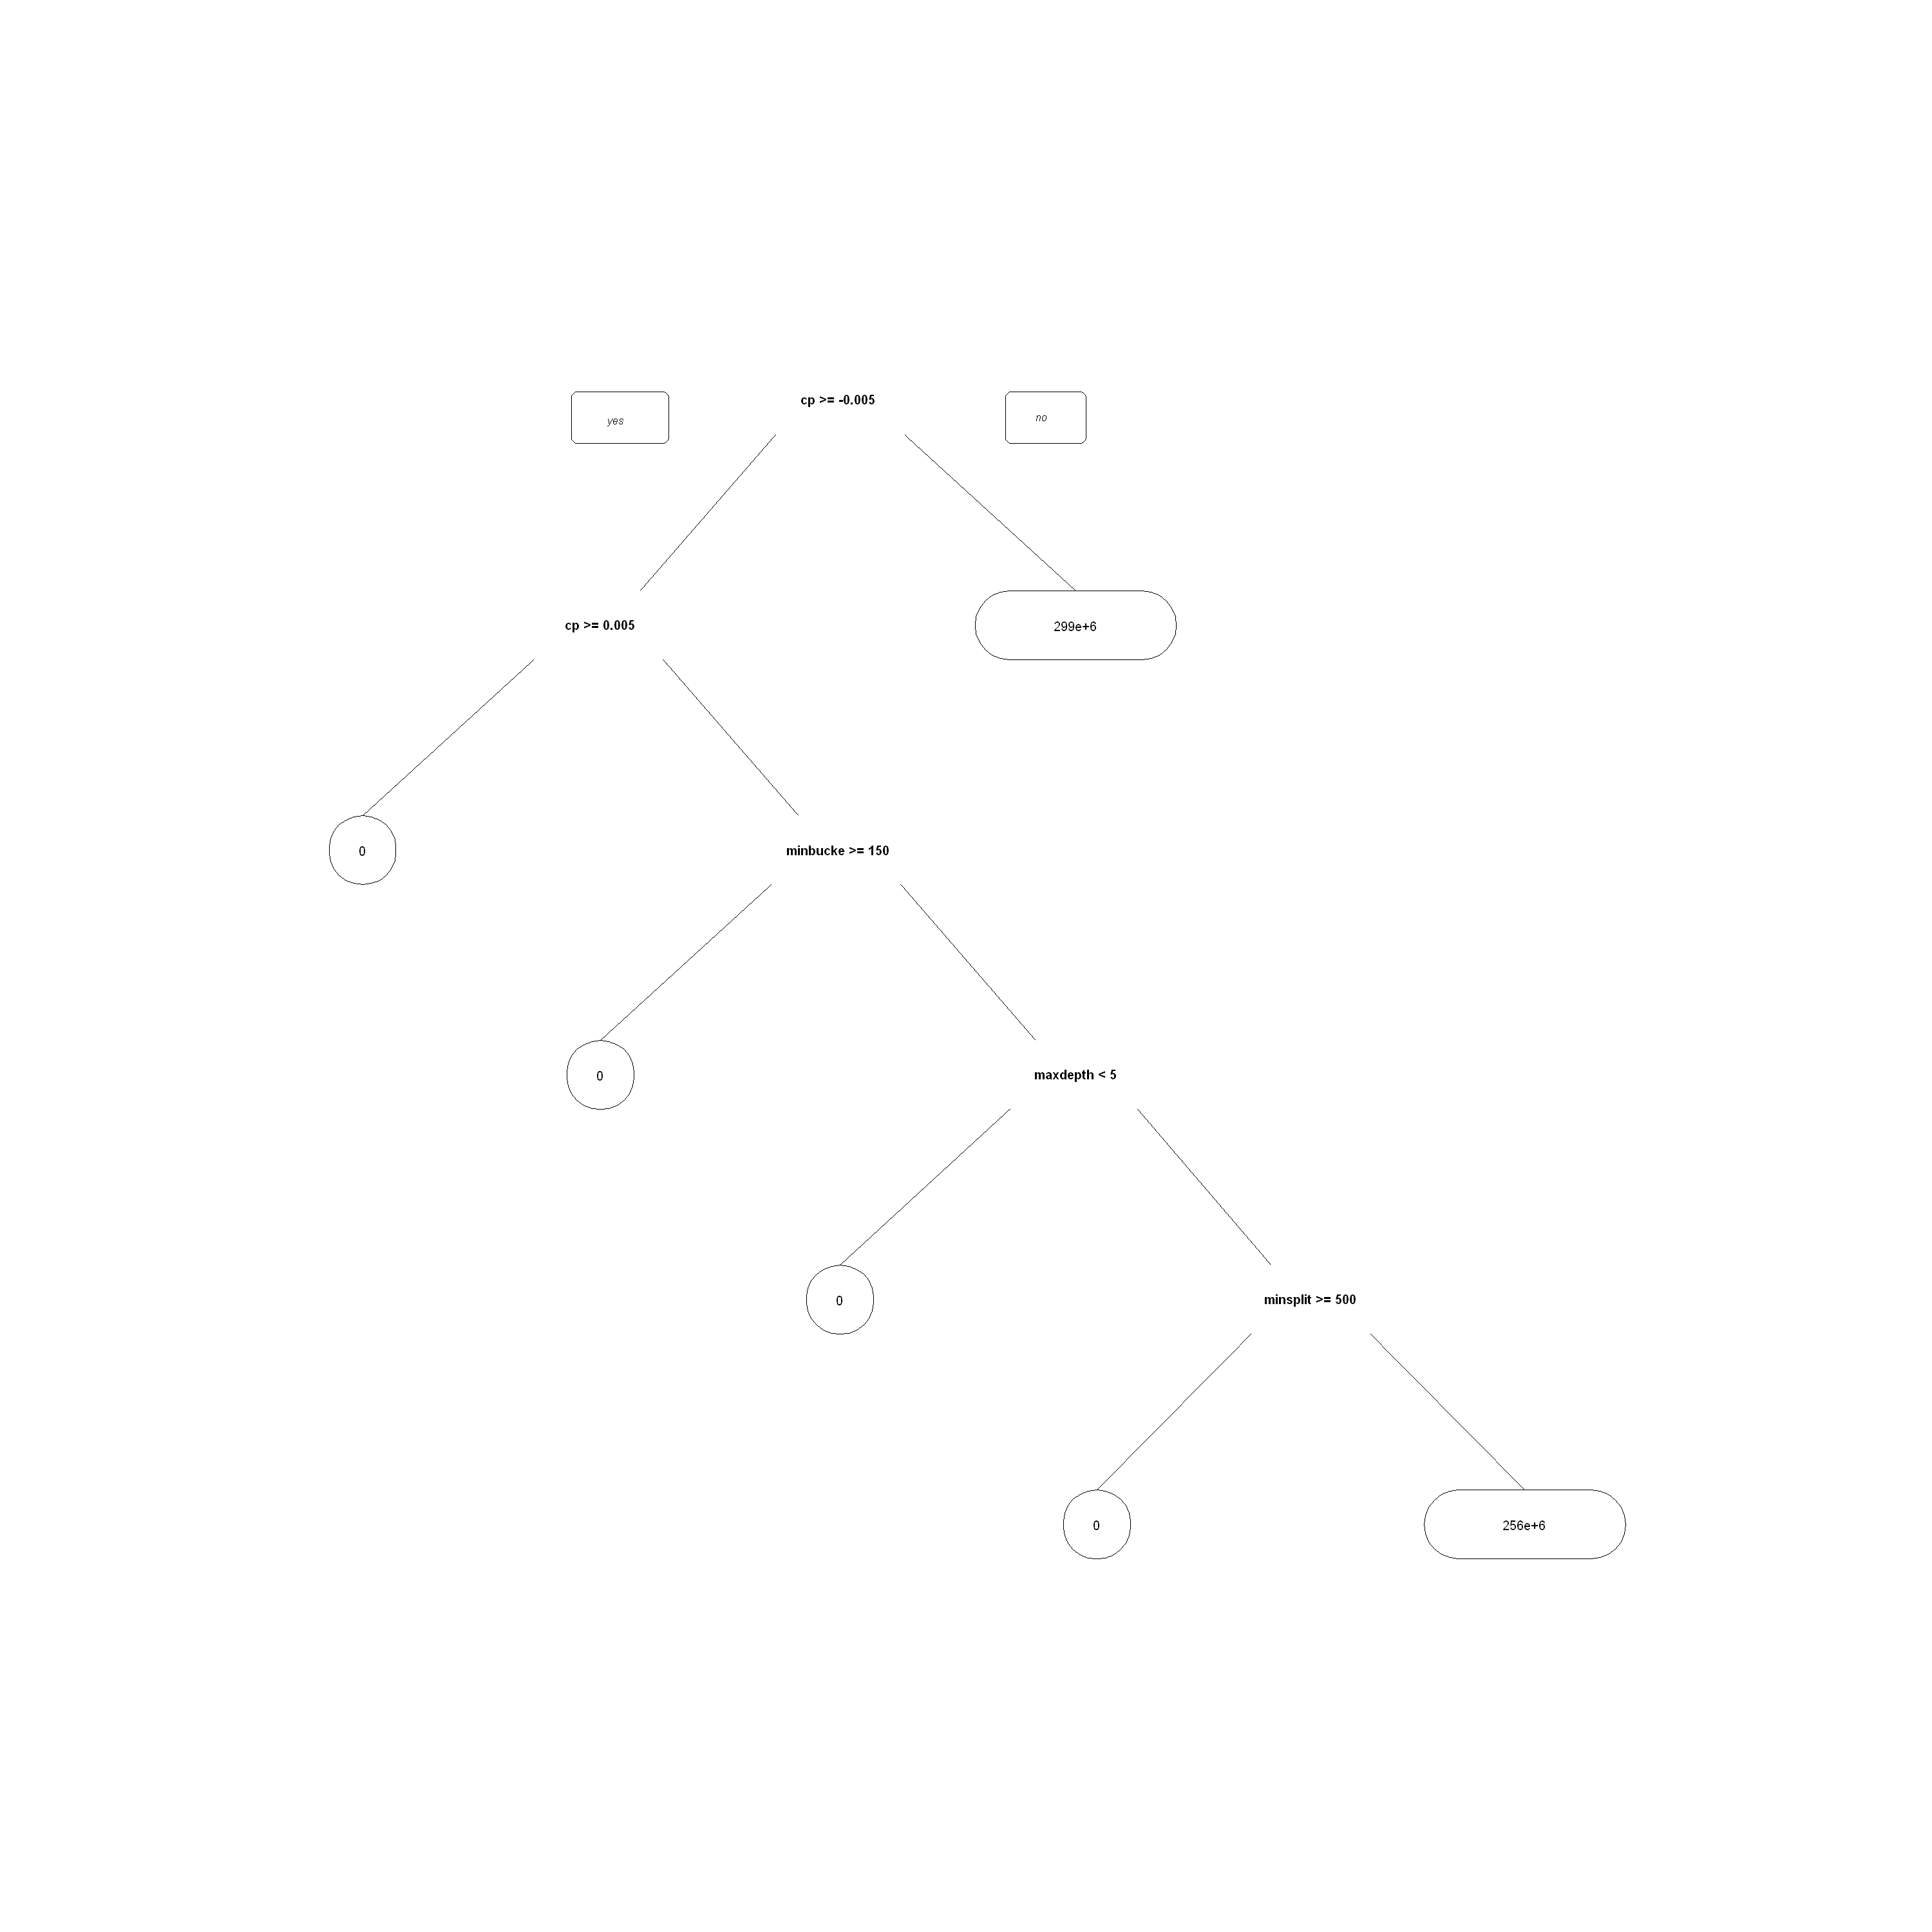

In [24]:
rpart.plot::prp(modelo)


Me ha salido una impresión del arbol, que es un solo nodo, pero solo dice continua.
<br>
leo la documentacion de la librería rpart.plot   https://cran.r-project.org/web/packages/rpart.plot/rpart.plot.pdf

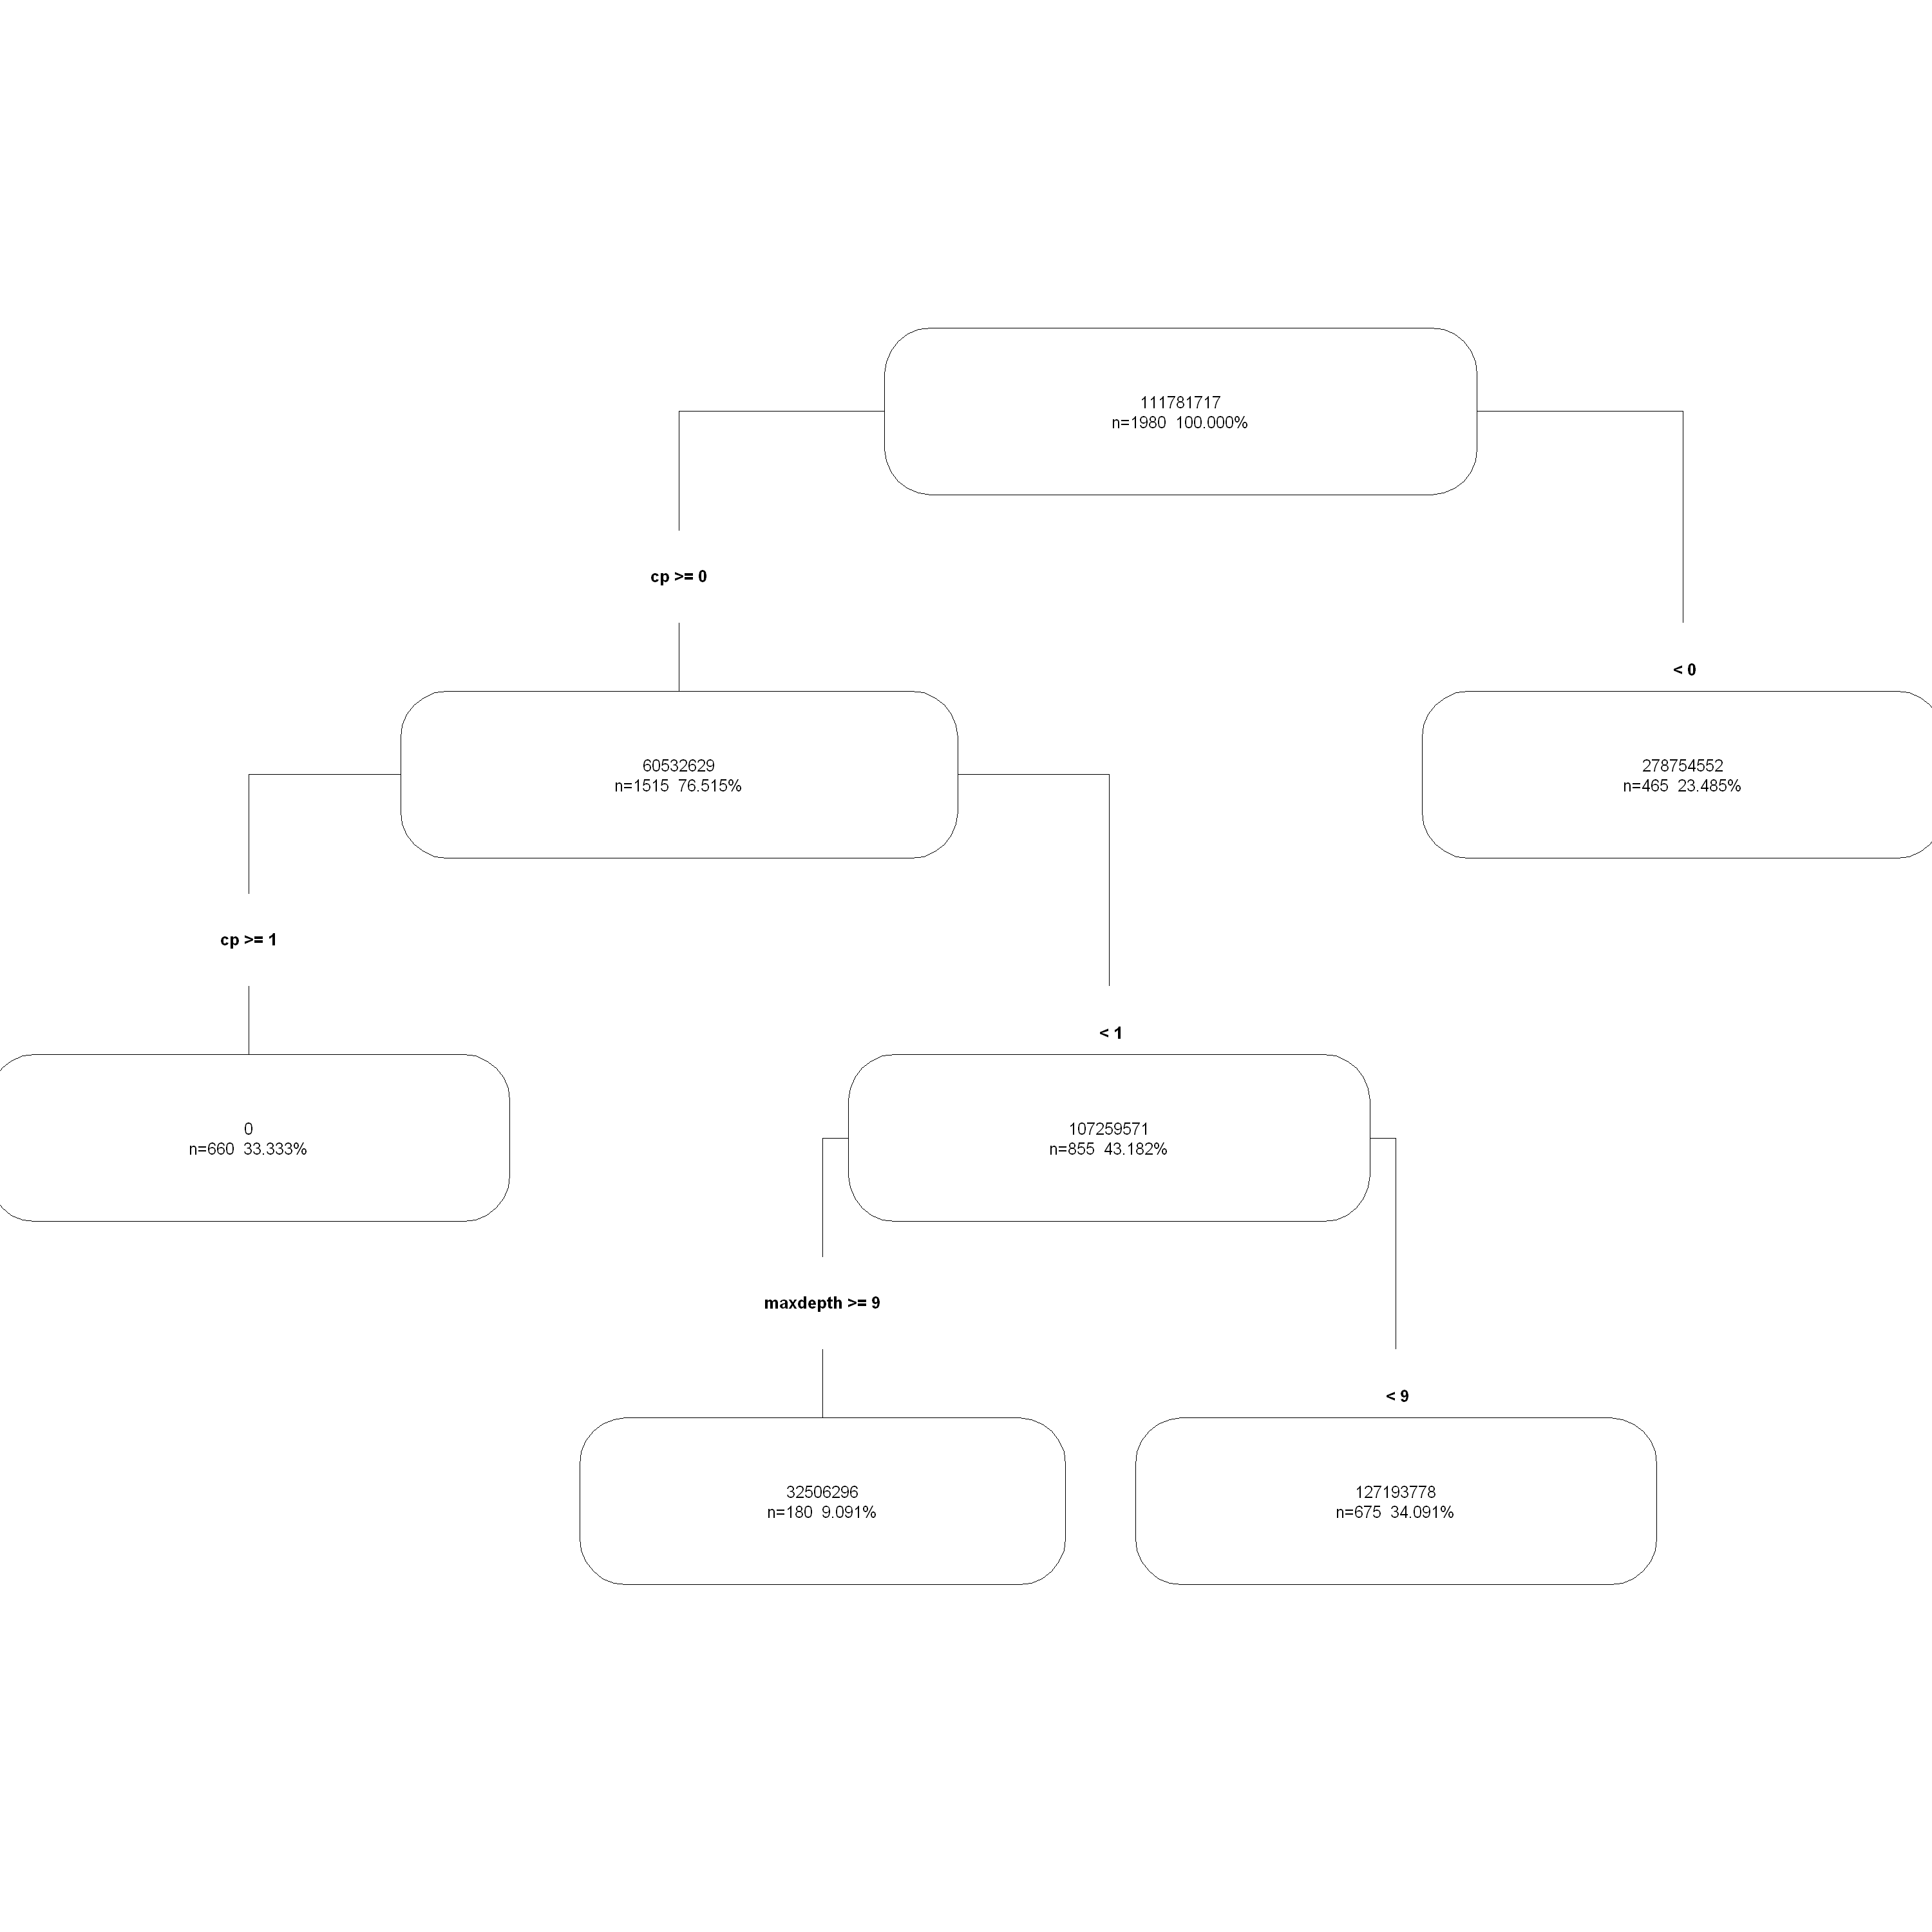

In [8]:
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.3)


Ha salido solo la raiz del arbol
<br>
Los tres numeros que muestra en el nodo con la cantidad de BAJA+1, BAJA+2 y CONTINUA, en ese orden, alfabetico.
<br>
la cantidad de CONTINUA   la está mostrando en notacion científica

### cambio hiperparámetros del arbol para salga algo mas que un solo nodo

El hiperparámetro cp  *complexity*   limita el split de los nodos.
<br>
El default es  cp=0.05
<br>
Pruebo con cp=0.0  a ver si "se abre el arbol"

Leo la documentación de la libreria rpart  https://cran.r-project.org/web/packages/rpart/rpart.pdf   y veo que existe un hiperparámetro de la funcion rpart  llamado **xval** que es para hacer cross validation, que por default viene seteado en xval=10 .   No me interesa en este momento que haga cross validation, para evitarlo voy a poner  *xval=0*

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


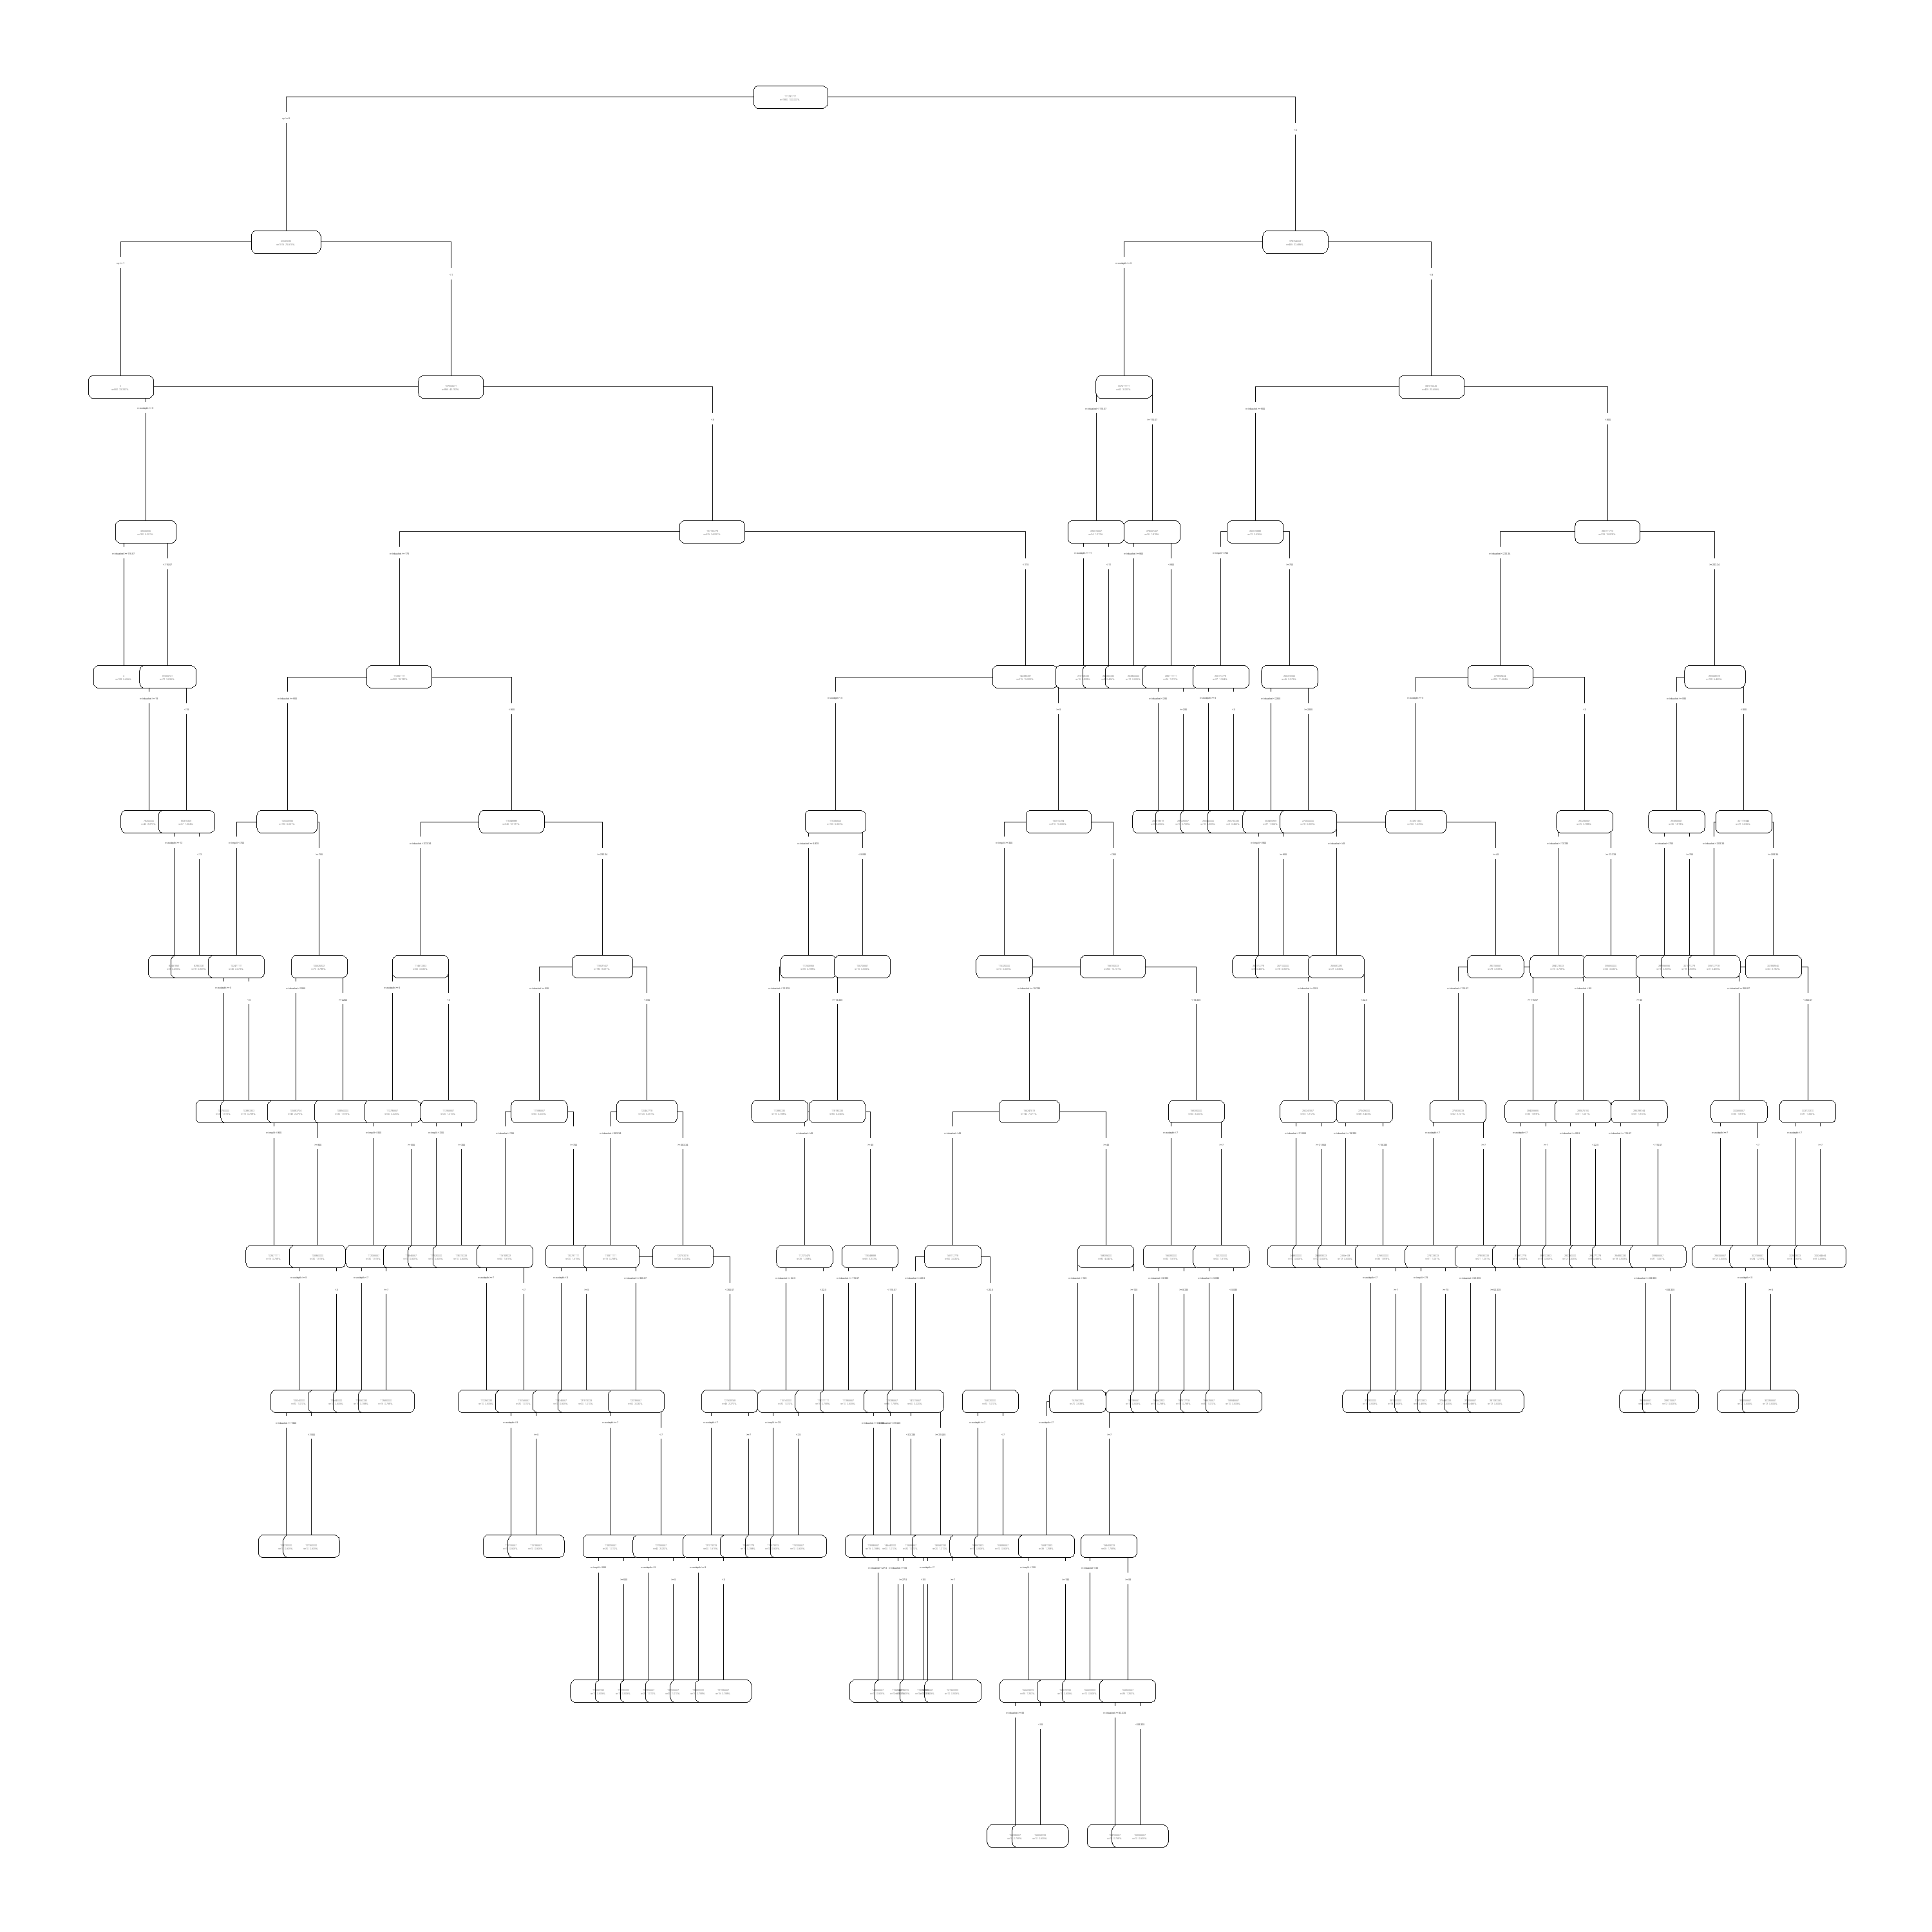

In [10]:
# genero el modelo
modelo <- rpart(
    formula = "ganancia_test ~ .",
    data = dataset,
    xval = 0,
    cp = 0.0
)

# imprimo el modelo graficamente
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.3)


sale un arbol de gran profundidad  que ni se puede visualizar
<br>
el mensaje  ""labs do not fit even at cex 0.15, there may be some overplotting"" me dice que no pudo dibujarlo correctamente
<br>
lamentablemente me doy cuenta la libreria rpart.plot es mala
<br>
establezco  maxdepth=2 para poder apreciarlo

Warning message:
"cex and tweak both specified, applying both"


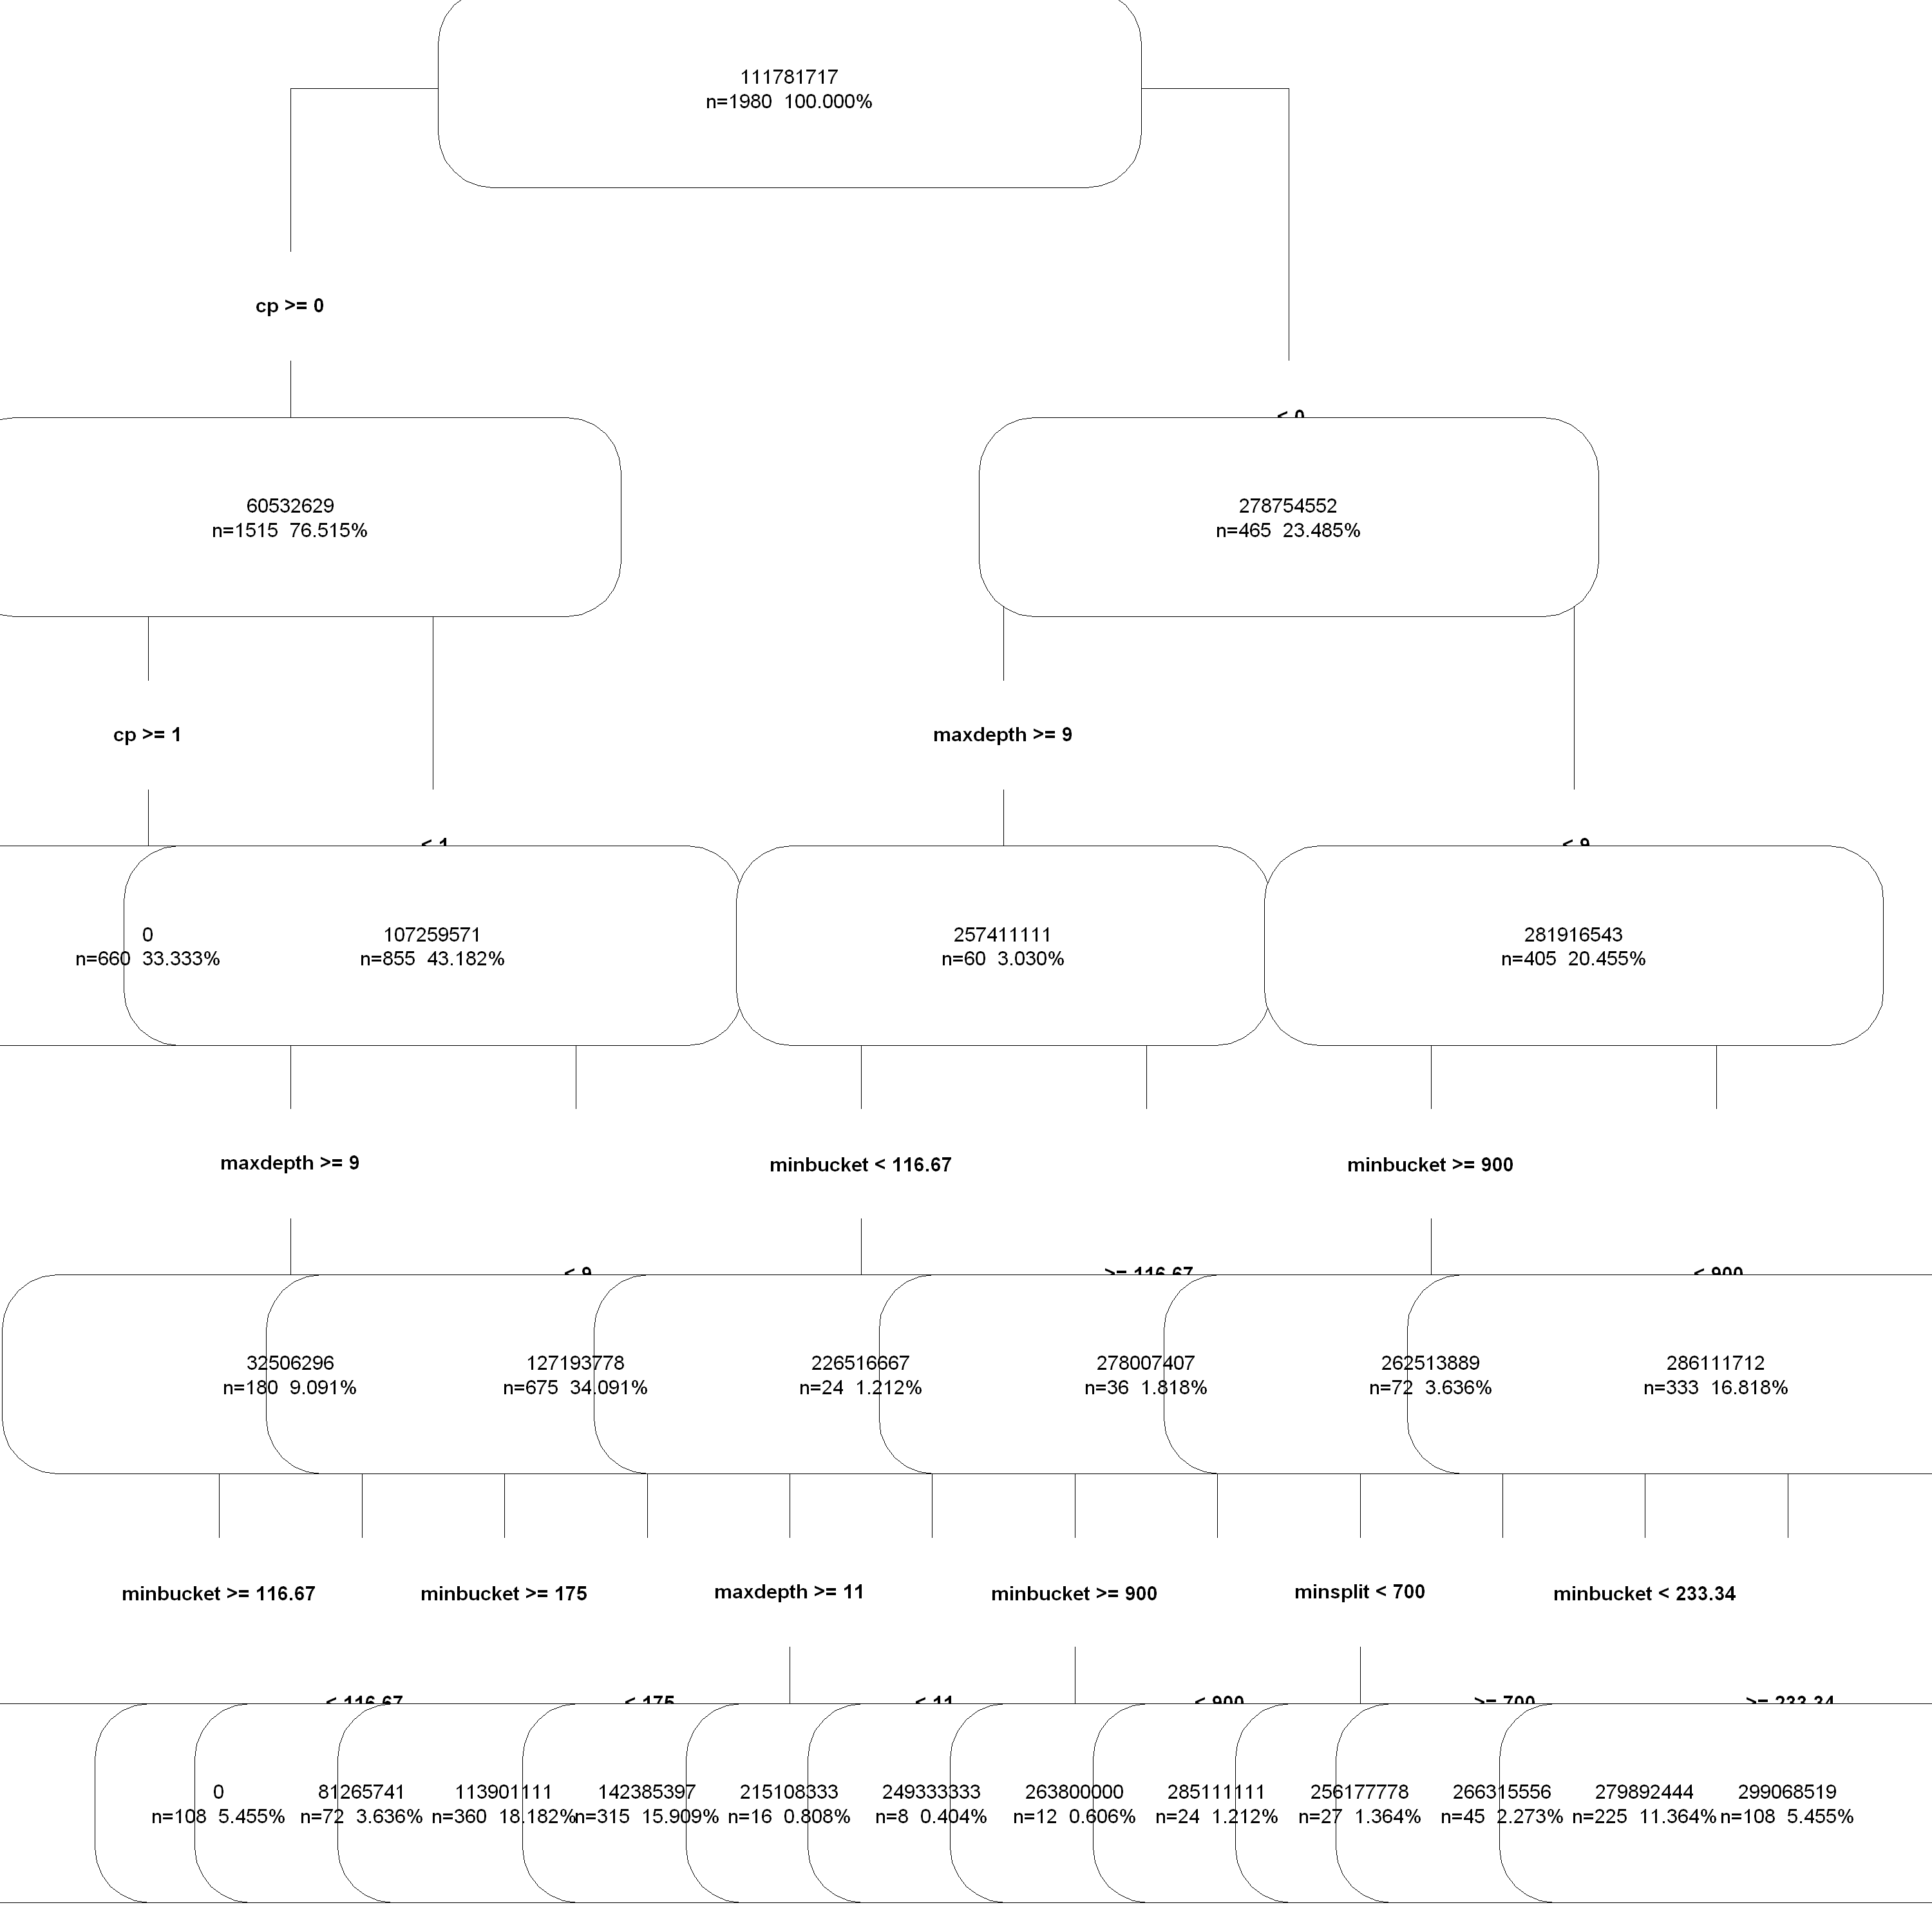

In [12]:
# genero el modelo
modelo <- rpart(
    formula = "ganancia_test ~ .",
    data = dataset,
    xval = 0,
    cp = 0.0,
    maxdepth = 4
)

# imprimo el modelo graficamente
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.3, cex = 1.2)


Esperaba ver un albol de profundidad 2 sin embargo, por alguna misteriosa razón, se ha generado un arbol con un solo nodo.
<br>
Corto por lo sano,  y establezco  cp=-1  para que siempre se abra el arbol

#genero el modelo
modelo < -rpart(formula="clase_ternaria ~ .",
    data=dataset1,
    xval=0,
    cp=-1,
    maxdepth=3)

#imprimo el modelo graficamente
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [ ]:
# genero el modelo
modelo <- rpart(
    formula = "clase_ternaria ~ .",
    data = dataset[foto_mes == 202104],
    xval = 0,
    cp = -1,
    maxdepth = 3
)

# imprimo el modelo graficamente
options(repr.plot.width = 40, repr.plot.height = 20)
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.1, cex = 1.2)


In [ ]:
# genero el modelo
dataset2 <- copy(dataset)
abril <- copy(dataset[foto_mes == 202104])
dataset2[foto_mes == 202106, clase_ternaria := "Z01"]
abril[, clase_ternaria := "Z01"]
dataset2 <- rbind(dataset2, abril)
dataset2[, foto_mes := NULL]
setorder(dataset2, clase_ternaria)

modelo <- rpart(
    formula = "clase_ternaria ~ . -Master_fultimo_cierre -Visa_fultimo_cierre -mcomisiones_mantenimiento",
    data = dataset2,
    xval = 0,
    cp = -1,
    maxdepth = 3
)

# imprimo el modelo graficamente
options(repr.plot.width = 40, repr.plot.height = 20)
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.1, cex = 1.2)


In [ ]:
modelo$splits


### Disgresión : aprendo a borrar la memoria

Listo los objetos que estan en la memoria de R en este momento

In [ ]:
ls()


creo una variable a ver que sucede

In [ ]:
a <- 1


me vuelvo a fijar que objtetos estan en la memoria, deberia aparecer la nueva variable **a**

In [ ]:
ls()


tal cual esperaba, aparece el nuevo objeto, la variable  **a**

Me fijo cuanta memoria esta disponible

In [ ]:
gc()


Borro **TODOS** los objetos que estan en la memoria de R

In [ ]:
rm(list = ls())


Me vuelvo a fijar cuanta memoria hay disponible

In [ ]:
gc()


llama a **gc()** garbaje collection, que me va a liberar mas aún la memoria
<br>
https://cran.r-project.org/web/packages/profmem/vignettes/profmem.html

Ahora si, limpie bore todos los objetos de R y limpie la memoria



---



## 1.04 Transformado (innecesariamente) las variables

El objetivo de esta sección es analizar el efecto que tiene sobre el arbol de decision
* Variables Colineales
* Normalizacion de Variables
* Transformada logarítmica
* Outliers

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table
library("rpart") # cargo la libreria  rpart
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")

options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory

In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset


In [ ]:
# genero el modelo
modelo <- rpart(
    formula = "clase_ternaria ~ .",
    data = dataset[foto_mes == 202104],
    xval = 0,
    cp = -1,
    maxdepth = 2
)

# imprimo el modelo graficamente
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.1, cex = 1.2)


La variable mas importante que aparece es **ctrx_quarter**

### variables colineales

agrego al dataset tres variables colineales  con ctrx_quarter

In [ ]:
dataset[foto_mes == 202104, ctrx_quarter_dos := 2 * ctrx_quarter]
dataset[foto_mes == 202104, ctrx_quarter_tres := 3 * ctrx_quarter]
dataset[foto_mes == 202104, ctrx_quarter_cuatro := 4 * ctrx_quarter]


y vuelvo a correr el arbol de decision

In [ ]:
# genero el modelo
modelo <- rpart(
    formula = "clase_ternaria ~ .",
    data = dataset[foto_mes == 202104],
    xval = 0,
    cp = -1,
    maxdepth = 2
)

# imprimo el modelo graficamente
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.1, cex = 1.2)


**SORPRENDENTE , el arbol de decision es inmune a las colinearidad de variables**
<br>
El arbol de decisión no ha cambiado. Su forma es exactamente igual, las cantidades en los nodos idéntica al arbol original.

###  Normalizacion de variables

Analizo la variable  ctrx_quarter

In [ ]:
min(dataset[foto_mes == 202104, ctrx_quarter])


In [ ]:
max(dataset[foto_mes == 202104, ctrx_quarter])


In [ ]:
boxplot(dataset[foto_mes == 202104, ctrx_quarter])


In [ ]:
hist(dataset[foto_mes == 202104, ctrx_quarter])


In [ ]:
plot(density(dataset[foto_mes == 202104, ctrx_quarter]))


Normailzo  ctrx_quarter

In [ ]:
dataset[foto_mes == 202104, ctrx_quarter_normalizado := scale(ctrx_quarter)]


confirmo que me quedó normalizada

In [ ]:
plot(density(dataset[foto_mes == 202104, ctrx_quarter_normalizado]))


Confirmado, la variable está normalizada, ahora corremos nuevamente el arbol de decision

In [ ]:
# genero el modelo
modelo <- rpart(
    formula = "clase_ternaria ~ .",
    data = dataset[foto_mes == 202104],
    xval = 0,
    cp = -1,
    maxdepth = 2
)

# imprimo el modelo graficamente
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.1, cex = 1.2)


**SORPRENDENTE , el arbol de decision es inmune a las normalizacion de variables**
<br>
El arbol de decisión no ha cambiado. Su forma es exactamente igual, las cantidades en los nodos idéntica al arbol original.
<br>

### Transformación  logaritmica

Primero vuelvo a cargar el dataset

In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset


hago la transformación logarítmica

In [ ]:
dataset[foto_mes == 202104, ctrx_quarter_log := log(ctrx_quarter + 1)] # sumo el uno porque no quiero infinitos


Ahora veo el boxplot

In [ ]:
boxplot(dataset[foto_mes == 202104, ctrx_quarter_log])


In [ ]:
plot(density(dataset[foto_mes == 202104, ctrx_quarter_log]))


Finalmente, el arbol de decision

Pero antes, ELIMINO del dataset la variable  ctrx_quarter , para que solo juegue  ctrx_quarter_log

In [ ]:
dataset[, ctrx_quarter := NULL]


In [ ]:
# genero el modelo
modelo <- rpart(
    formula = "clase_ternaria ~ .",
    data = dataset[foto_mes == 202104],
    xval = 0,
    cp = -1,
    maxdepth = 2
)

# imprimo el modelo graficamente
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.1, cex = 1.2)


**SORPRENDENTE , el arbol de decision es inmune a la transformada logaritmica**
<br>
El arbol de decisión no ha cambiado. Su forma es exactamente igual, las cantidades en los nodos idéntica al arbol original.
<br>
Por supuesto, el arbol original cortaba en  ctrx_quarter < 10 y ahora corta en ctrx_quarter < 2.35 porque obviamente alteré esa variable, pero en realidad está cortando en el mismo punto.

### Outliers

Ahora fabrico outliers y veo como se comporta el arbol

Primero vuelvo a cargar el dataset

In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset


el boxplot original

In [ ]:
boxplot(dataset[foto_mes == 202104, ctrx_quarter])


cuento cuantos registros hay con ctrx_quarter > 1500

In [ ]:
dataset[foto_mes == 202104 & ctrx_quarter > 1500, .N]


## Ahora, a esos valores los transformo en outliers extremos

In [ ]:
dataset[foto_mes == 202104 & ctrx_quarter > 1500, ctrx_quarter := ctrx_quarter * 1000]


compruebo que sean outliers extremos

In [ ]:
boxplot(dataset[foto_mes == 202104, ctrx_quarter])


Finalmente, nuevamente arbol de decision

In [ ]:
# genero el modelo
modelo <- rpart(
    formula = "clase_ternaria ~ .",
    data = dataset[foto_mes == 202104],
    xval = 0,
    cp = -1,
    maxdepth = 2
)

# imprimo el modelo graficamente
prp(modelo, extra = 101, digits = -5, branch = 1, type = 4, varlen = 0, faclen = 0, tweak = 1.1, cex = 1.2)


**SORPRENDENTE, el arbol de decision es inmune a los outliers**
<br>
El arbol de decisión no ha cambiado. Su forma es exactamente igual, las cantidades en los nodos idéntica al arbol original.
<br>

### Si usted considera que fueron muy conservador convertir en outliers a tan solo 19 registros a que sean outliers, pruebe con  ctrx_quarter > 1000



---



## 1.05 Creando un data.table a partir de las columnas

Hasta ahora, para crear una data.table estamos leyendo un archivo del disco ( o bajándolo de internet)
<bv>
 Ahora veremos como crearla a partir de dos vectores   

El objetivo de esta sección es analizar el efecto que tiene sobre el arbol de decision
* Variables Colineales
* Normalizacion de Variables
* Transformada logarítmica
* Outliers

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table

options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory

Supongamos que tengo dos vectores, uno con *numero_de_clente*  y otro con la decision de si a ese registro le envio o no estímulo
<br>
Importante :  ambos vectores tienen la misma longitud

In [ ]:
vector_ids <- c(107, 228, 351, 468, 579)


In [ ]:
vector_ids


In [ ]:
vector_enviar <- c(0, 1, 1, 0, 1)


In [ ]:
vector_ids


finalmente creo un dataset a partir de las dos columnas
<br>
a la primer columna la voy a llamar  "numero_de_cliente"
<bv>
a la segunda columna la voy a llamar  "Predicted"

En el lenguaje R, un dataframe o data.table es una lista de columnas
<br>
es una lsita y no un vector, porque los vectores necesitan que todos los valores sean del mismo tipo de datos
<br>
pero un dataset puede tener columnas que sean vectores de numeros, vectores de cadenas de caracters (string)
<br>
en R,  exista el tipo  **list**  , para meter en  *una bolsa de gatos* objetos de distinto tipo

In [ ]:
tabla_final <- as.data.table(list(
    "numero_de_cliente" = vector_ids,
    "Predicted" = vector_enviar
))


veo como qyuedó la nueva data.table

In [ ]:
tabla_final


Finalmente,  grabo ese archivo con la instruccion  **fwrite**  que pertenece a la libreria  **data.table

Cuando utilizamos la instruccion **fread** para leer una data.table , ella tiene la inteligencia de darse cuenta cual es el separador de campos
<br>
pero para grabar, necesitamos nosotros especificarle cual queremos que sea el separador de campos

In [ ]:
# genero el archivo para Kaggle
# creo la carpeta donde va el experimento
dir.create("./ZH2015/", showWarnings = FALSE)

fwrite(tabla_final,
    file = "./ZH2015/entrega_de_juguete.csv",
    sep = ","
)


Revisar ahora que hay en la carpeta **/exp/ZH2015/** , editar el archvo  entrega_de juguete.txt
<br>
Este archivo de juguete dará error si se sube a Kaggle, fue solo de ejemplo



---



## 1.06 (capítulo eliminado en año 2025 )

## 1.07 Aplicando el arbol

Se aplicará el modelo generado por rpart a los datos nuevos y se genera la salida para Kaggle

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table
library("rpart") # cargo la libreria  rpart
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")

options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory
dir.create("./ZH2017/", showWarnings = FALSE)
setwd("/content/buckets/b1/exp/ZH2017/") # Establezco el Working Directory


In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset


In [ ]:
dtrain <- dataset[foto_mes == 202104]
dapply <- dataset[foto_mes == 202106]


In [ ]:
# genero el modelo
modelo <- rpart::rpart(
    formula = "clase_ternaria ~ .",
    data = dtrain,
    xval = 0,
    cp = -1,
    maxdepth = 2
)


Aplico el modelo a los datos dapply  pidiendo que me devuelva probabildades

In [ ]:
prediccion <- predict(modelo, dapply, type = "prob")


Analizo que queda en prediccion

In [ ]:
head(prediccion)


Prediccion es una matriz; me interesa la columna "BAJA+2"  que es la probabilidad que modelo asigna a cada registro de dapply

In [ ]:
prob_baja2 <- prediccion[, "BAJA+2"]


In [ ]:
head(prob_baja2)


prob_baja2 es el vector de probabilidades

In [ ]:
length(prob_baja2)
nrow(dapply)


Ahora decido si envio el estimulo o no
<br>
si prob( BAJA+2) > 0.025  envio  el estímulo

In [ ]:
Predicted <- ifelse(prob_baja2 > 0.025, 1, 0)


In [ ]:
head(Predicted)


In [ ]:
hist(Predicted)


creo una tabla con  lo que voy a enviar a Kaggle

In [ ]:
tb_prediccion <- as.data.table(list("numero_de_cliente" = dapply$numero_de_cliente, "Predicted" = Predicted))


In [ ]:
head(tb_prediccion)


In [ ]:
tb_prediccion[, .N, Predicted]


Esto significa que se enviaran 8080 estímulos

In [ ]:
# genero el archivo para Kaggle
# creo la carpeta donde va el experimento

fwrite(tb_prediccion,
        file = "para_Kaggle_0107.csv",
        sep = ","
)




---



## 1.08 Unos buenos hiperparametros

Se aplicará el modelo generado por rpart a los datos nuevos y se genera la salida para Kaggle

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table
library("rpart") # cargo la libreria  rpart
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")

options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory
dir.create("./ZH2018/", showWarnings = FALSE)
setwd("/content/buckets/b1/exp/ZH2018/") # Establezco el Working Directory


In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset


In [ ]:
dtrain <- dataset[foto_mes == 202104]
dapply <- dataset[foto_mes == 202106]


defino unos parametros interesantes
<br>
los hiperparametros van en una lista
<br>
notar la forma en que esos parametros se pasan a la funcion rpart

In [ ]:
param <- list(
    "cp" = -0.5,
    "minsplit" = 900,
    "minbucket" = 440,
    "maxdepth" = 5
)


In [ ]:
# genero el modelo
modelo <- rpart::rpart(
    formula = "clase_ternaria ~ .",
    data = dtrain,
    xval = 0,
    control = param
)


Aplico el modelo a los datos dapply  pidiendo que me devuelva probabildades

In [ ]:
prediccion <- predict(modelo, dapply, type = "prob")


Genero la salida

In [ ]:
prob_baja2 <- prediccion[, "BAJA+2"]
Predicted <- ifelse(prob_baja2 > 0.025, 1, 0) # 0.025 es la probabilidad de corte

entrega <- as.data.table(list("numero_de_cliente" = dapply$numero_de_cliente, "Predicted" = Predicted))

# creo la carpeta donde va el experimento
dir.create("./exp/", showWarnings = FALSE)
dir.create("./exp/ZH2018/", showWarnings = FALSE)

# genero el archivo para Kaggle
fwrite(entrega,
        file = "para_Kaggle_0108.csv",
        sep = ","
)


¿Qué aparece en el Public Leaderboard?



---



## 1.09 Dividir en Training y Testing
## version libreria caret

El objetivo es hacer una division del dataset en training/testing que sea estratificada en la clase
<br>
https://es.wikipedia.org/wiki/Muestreo_estratificado

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table

options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory
dir.create("./ZH2019/", showWarnings = FALSE)
setwd("/content/buckets/b1/exp/ZH2019/") # Establezco el Working Directory


In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset


In [ ]:
dabril <- dataset[foto_mes == 202104]


In [ ]:
if (!require("caret")) install.packages("caret")
require("caret")

https://www.rdocumentation.org/packages/caret/versions/6.0-88/topics/createDataPartition
<br>
la funcion  **createDataPartition** devolverá un vector de posiciones, las que cumplen con la particion indicada
<br>
*p= 0.5* significa que queremos el 50% de los registros
<br>
*dataset$clase_ternaria*   es el vector con la clase ternaria, que es por donde se estratificará
<br>

In [ ]:
train_rows <- createDataPartition(dabril$clase_ternaria, p = 0.50, list = FALSE)


veamos que ha quedado en  los primeros registros del vector **train_rows**

In [ ]:
head(train_rows)


Aqui ya vemos que la particion tiene un suconjunto de los registros

ahora creamos los datasets de training y testing

In [ ]:
dtrain <- dabril[train_rows]


-train_rows  significa el complemento  (no confundir con numeros negativos)

In [ ]:
dtest <- dabril[-train_rows]


Compruebo la division

In [ ]:
nrow(dtrain)
nrow(dtest)
nrow(dtrain) + nrow(dtest)
nrow(dabril)


Compruebo que la particion es estratificada

In [ ]:
dabril[, .N, clase_ternaria]
dtrain[, .N, clase_ternaria]
dtest[, .N, clase_ternaria]


La division se ha construido en forma perfectamente estratificada !



---



## 1.10 Experimentos con azar Replicables
## set.seed()

El objetivo es hacer una division del dataset en training/testing que sea estratificada en la clase
<br>
https://es.wikipedia.org/wiki/Muestreo_estratificado

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table
library("rpart") # cargo la libreria  data.table
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")
if (!require("caret")) install.packages("caret")
require("caret")

options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory
dir.create("./ZH2020/", showWarnings = FALSE)
setwd("/content/buckets/b1/exp/ZH2020/") # Establezco el Working Directory


In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset


In [ ]:
dabril <- dataset[foto_mes == 202104]


In [ ]:
train_rows <- createDataPartition(dabril$clase_ternaria, p = 0.50, list = FALSE)


In [ ]:
head(train_rows)


Volvamos a dividir crear una particion a ver si sale lo mismo

In [ ]:
train_rows <- createDataPartition(dabril$clase_ternaria, p = 0.50, list = FALSE)
head(train_rows)


Cáspitas !  No ha salido la misma particion.
<br>
Si yo quiero replicar el mismo experimento, no lo voy a poder hacer, ya que la division entre training y testing va a ser distinta

### Ahora la solucion !

La solucion es setear la semilla del generador de numeros pseudoaleatorios de R

In [ ]:
set.seed(13)


In [ ]:
train_rows <- createDataPartition(dabril$clase_ternaria, p = 0.50, list = FALSE)
head(train_rows)


Y ahora nuevamente

In [ ]:
set.seed(13) # uso la misma semilla que antes
train_rows <- createDataPartition(dabril$clase_ternaria, p = 0.50, list = FALSE)
head(train_rows)


Enhorabuena !  la particion es exactamente la misma
<br>
el set.seed() me permitirá replicar experimentos con exactitud



---



## 1.11 Arbol training/testing

El objetivo es calcular la ganancia en testing de un arbol de decision

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table
library("rpart") # cargo la libreria  rpart
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")
if (!require("caret")) install.packages("caret")
require("caret")


options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory
dir.create("./ZH2021/", showWarnings = FALSE)
setwd("/content/buckets/b1/exp/ZH2021/") # Establezco el Working Directory


In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset


In [ ]:

dataset <- dataset[foto_mes == 202104] # me quedo solo con el periodo 202104


In [ ]:
# creo training con 70%  y testing con 30%
set.seed(13)
train_rows <- createDataPartition(dataset$clase_ternaria, p = 0.70, list = FALSE)
dtrain <- dataset[train_rows]
dtest <- dataset[-train_rows]


Entreno el modelo en los datos de training

In [ ]:
param <- list(
    "cp" = -0.5,
    "minsplit" = 900,
    "minbucket" = 440,
    "maxdepth" = 5
)


Entreno el modelo en los datos de training

In [ ]:
# genero el modelo
modelo <- rpart::rpart(
    formula = "clase_ternaria ~ .",
    data = dtrain,
    xval = 0,
    control = param
)


aplico el modelo a los datos de testing

In [ ]:
prediccion <- predict(modelo, dtest, type = "prob")


### Calculo la ganancia del modelo en los datos de testing

a partir de la prediccion, calculo la probabilidad de BAJA+2 de cada registro de testing  **dtest**

In [ ]:
prob_baja2 <- prediccion[, "BAJA+2"]


Para el cálculo de la ganancia del modelo aplicado a testing debo tener en cuenta lo siguiente
* Solo envio estimulo a los registros que el modelo asigno una probabilidad mayor a 0.025
* Si no envio estimulo, no gano ni pierdo, es decir la ganacia es cero
* Si el registro al que envio el estímulo es un **BAJA+2**  entonces la ganancia es de +780000
* Si el registro al que envio el estímulo es un **BAJA+1**  entonces la ganancia es de  -20000
* Si el registro al que envio el estímulo es un **CONTINUA** entonces la ganancia es de  -20000

##### A la condición que solo envio a los registros con probabilidad mayor a 1/40 la resuelvo con la condicion lógica  (prob_baja2> 0.025)
<br>
Esta condicion termina siendo un 0 o un 1
<br>
vale 1 si y solo si se cumple la condicion, es decir  si prob_baja2 es mayor a 0.025

### La ganancia de +780000 o -20000 la resuelvo de esta forma ifelse( clase_ternaria=="BAJA+2", 780000, -20000)

Finalmente,  que se cumplan ambas condiciones al mismo tiempo, en este caso, es multiplicarlas, o sea
<br>
(prob_baja2> 0.025) * ifelse( clase_ternaria=="BAJA+2", 780000, -20000)
<br>
La condicion anterior toma los siguientes valores

| prob(BAJA+2) | clase_ternaria | ganancia |
| --- | :---: | ---: |
| menor o igual a 0.025 | BAJA+1 | 0 |
| menor o igual a 0.025 | CONTINUA | 0 |
| menor o igual a 0.025 | BAJA+2 | 0 |
| mayor a 0.025 | BAJA+1 | -20000 |
| mayor a 0.025 | CONTINUA | -20000 |
| mayor a 0.025 | BAJA+2 | 780000 |


Finalmente hago el calculo en data.table

In [ ]:
ganancia_testing <- dtest[, sum((prob_baja2 > 0.025) * ifelse(clase_ternaria == "BAJA+2", 780000, -20000))]


In [ ]:
ganancia_testing


Es importante que la ganancia esta calculada sobre los datos de testing, que en este caso son apenas el 30%
<br>
Si quiero extrapolar a todo el dataset, debo hacer el **cociente** de esa ganancia por 0.30   ( coloquialmente, debo dividir por 0.30 )

In [ ]:
ganancia_testing_normalizada <- ganancia_testing / 0.3


In [ ]:
ganancia_testing_normalizada




---



## 1.12 Funcion de Ganancia de Arbol training/testing

El objetivo es poner el notebook anterior dentro de una funcion, e invocarla con distintas semillas, para maravillarnos ante la dispersion de las ganancias

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table
library("rpart") # cargo la libreria  data.table
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")
if (!require("caret")) install.packages("caret")
require("caret")

options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory
dir.create("./ZH2022/", showWarnings = FALSE)
setwd("/content/buckets/b1/exp/ZH2022/") # Establezco el Working Directory


In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset
dataset <- dataset[foto_mes == 202104] # me quedo solo con el periodo 202104


In [ ]:
GananciaArbol <- function(semilla, data, x, train = 0.70) {
  # establezco la semilla
  set.seed(semilla)
  train_rows <- createDataPartition(dataset$clase_ternaria, p = 0.70, list = FALSE)

  modelo <- rpart::rpart(
    formula = "clase_ternaria ~ .",
    data = data[train_rows], # los datos de training
    xval = 0,
    control = x
  )

  # Aplico el modelo a los datos de testing
  prediccion <- predict(modelo, data[-train_rows], type = "prob")

  prob_baja2 <- prediccion[, "BAJA+2"]
  ganancia_testing <- data[-train_rows, sum((prob_baja2 > 0.025) * ifelse(clase_ternaria == "BAJA+2", 780000, -20000))]

  return(ganancia_testing)
}


Vale la pena notar que dentro de la funcion no se han creado  dtrain y dtest,  sino que directamente se utilizan:
* data[ train_rows]  como training
* data[ -train_rows]  como testing


#Aqui empieza el programa

In [ ]:
# defino unos buenos hiperparametros
param <- list(
    "cp" = -0.5,
    "minsplit" = 500,
    "minbucket" = 10,
    "maxdepth" = 5
)


In [ ]:
# Ahora hago algunas llamadas a la funcion


In [ ]:
GananciaArbol(11, dataset, x = param)


In [ ]:
GananciaArbol(13, dataset, x = param)


In [ ]:
GananciaArbol(17, dataset, x = param)


In [ ]:
GananciaArbol(19, dataset, x = param)


In [ ]:
GananciaArbol(23, dataset, x = param)


Lo primero que se obseva es la variabilidad de la ganancia sin normalizar segun la semilla, hasta un 10%

Esta dispersión es **NOTABLE**  ya que el algoritmo es el mismo, con los mismos parámetros.
<br>
Lo único que cambia es que datos se utilizan para entrenar y testear, pero siempre es 70% / 30%
<br>
Es más notable aún que se ha tenido cuidado que la partición sea estratificada segun el campo **clase_ternaria**, lo que apriori uno supondria que va a generar particiones muy homogéneas.



---



## 1.13  Acumulando resultados en un vector

Este elemental notebook muestra desde cero como acumular resultados en un vector, será un primer paso para luego escribir scripts en donde guardemos los resultados de nuestros procesos en vectores o en un dataset si es necesario.

Partimos primero de un vector, al que queremos agregarle al final un elemento nuevo

In [ ]:
vector <- c(1, 2, 3, 4, 5)


In [ ]:
vector


agregar un elemento al final, a  **vector** , es tan simple como

In [ ]:
vector <- c(vector, 6)


In [ ]:
vector


Ahora definimos una funcion para ejemplificar

In [ ]:
potencia_invertida <- function(x) {
    return(1 / 2^x)
}


In [ ]:
# creo el vector vacio donde voy a acumular


In [ ]:
resultados <- c()


Lo siguiente es la instruccion  **for**  
<br>
Lo razón mas importante de existir de las computadoras es poder computar en donde se pueda repitir algo  **muchas veces**
<br>
Cuando está fija la cantidad de veces que se va a repetir algo, se utiliza la instruccion **for**

In [ ]:
for (x in 1:8){
    y <- potencia_invertida(x)
    resultados <- c(resultados, y)

    cat(resultados, "\n")
}


Me fijo que tiene resultados

Se observa como va creciendo el vector, agregando a cada paso el nuevo resultado

In [ ]:
resultados


finalmente,  de curiosidad, sumo los primeros 100 terminos

In [ ]:
resultados <- c()


In [ ]:
for (x in 1:100)
{
    y <- potencia_invertida(x)
    resultados <- c(resultados, y)
}


In [ ]:
resultados


In [ ]:
sum(resultados)


El resultado es 1 ,  como se esperaba matematicamente

### Otra forma de hacer lo anterior, trabajando con vectores en R es la siguiente  ( este sería el RStyle )

defino el vector como la secuencia de numeros del 1 al 100

In [ ]:
vector <- 1:100


verifico que el vector tiene lo que necesito

In [ ]:
vector


calculo la operacion matematica de 1/(2^x)  pero aplicándola a TODO el vector

In [ ]:
resultados <- 1 / (2^vector)


verifico que hay en resultados

calculo la suma de lo que quedó en el vector resultados

In [ ]:
sum(resultados)


Efectivamente me da 1, igual que la forma anterior de calcularlo

Hemos visto DOS formas de hacer un calculo, el elemental con la instruccion  **for**  y el vectorial de R

Obviamente,  R internamente resuelve el calculo vectorial haciendo un **for**



---



## 1.14 Montecarlo Estimation, Arbol
## con un for loop

El objetivo es implementar con un for loop la estimacion montecarlo, que promedia las ganancias

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table
library("rpart") # cargo la libreria  data.table
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")
if (!require("caret")) install.packages("caret")
require("caret")

options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory
dir.create("./ZH2024/", showWarnings = FALSE)
setwd("/content/buckets/b1/exp/ZH2024/") # Establezco el Working Directory


In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset
dataset <- dataset[foto_mes == 202104] # me quedo solo con el periodo 202104


La funcion que definimos en el notebook anterior

In [ ]:
GananciaArbol <- function(semilla, data, x, train = 0.70) {
  # establezco la semilla
  set.seed(semilla)
  train_rows <- createDataPartition(dataset$clase_ternaria, p = 0.70, list = FALSE)

  modelo <- rpart::rpart(
    formula = "clase_ternaria ~ .",
    data = data[train_rows], # los datos de training
    xval = 0,
    control = x
  )

  # Aplico el modelo a los datos de testing
  prediccion <- predict(modelo, data[-train_rows], type = "prob")

  prob_baja2 <- prediccion[, "BAJA+2"]
  ganancia_testing <- data[-train_rows, sum((prob_baja2 > 0.025) * ifelse(clase_ternaria == "BAJA+2", 780000, -20000))]

  # normalizo la ganancia
  ganancia_testing_normalizada <- ganancia_testing / 0.3

  return(ganancia_testing_normalizada)
}


In [ ]:
# defino unos buenos hiperparametros
param <- list(
    "cp" = -0.5,
    "minsplit" = 900,
    "minbucket" = 440,
    "maxdepth" = 5
)


In [ ]:
# defino el vector de semillas


In [ ]:
ksemillas <- c(102191, 200177, 410551, 552581, 892237) # reemplazar por las propias semillas


In [ ]:
vector_ganancias <- c() # vector donde voy a ir acumulando las ganancias


In [ ]:
for (semilla in ksemillas)
{
    ganancia <- GananciaArbol(semilla, dataset, x = param, train = 0.70)
    vector_ganancias <- c(vector_ganancias, ganancia)
}


veo que tiene  vector_ganancias

In [ ]:
vector_ganancias


Calculo la media de  vector_ganancias

In [ ]:
mean(vector_ganancias)




---



## 1.15 Montecarlo Estimation, Arbol
## En una funcion

El objetivo es implementar con un for loop la estimacion montecarlo, que promedia las ganancias

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

In [ ]:
library("data.table") # cargo la libreria  data.table
library("rpart") # cargo la libreria  data.table
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")
if (!require("caret")) install.packages("caret")
require("caret")

options(repr.plot.width = 20, repr.plot.height = 10)

In [ ]:
setwd("/content/buckets/b1/exp") # Establezco el Working Directory
dir.create("./ZH2025/", showWarnings = FALSE)
setwd("/content/buckets/b1/exp/ZH2025/") # Establezco el Working Directory


In [ ]:
dataset <- fread("/content/datasets/competencia_01.csv.gz") # cargo el dataset
dataset <- dataset[foto_mes == 202104] # me quedo solo con el periodo 202104


La funcion que definimos en el notebook anterior

In [ ]:
GananciaArbol <- function(semilla, data, x, train = 0.70) {
  # establezco la semilla
  set.seed(semilla)
  train_rows <- createDataPartition(dataset$clase_ternaria, p = 0.70, list = FALSE)

  modelo <- rpart::rpart(
    formula = "clase_ternaria ~ .",
    data = data[train_rows], # los datos de training
    xval = 0,
    control = x
  )

  # Aplico el modelo a los datos de testing
  prediccion <- predict(modelo, data[-train_rows], type = "prob")

  prob_baja2 <- prediccion[, "BAJA+2"]
  ganancia_testing <- data[-train_rows, sum((prob_baja2 > 0.025) * ifelse(clase_ternaria == "BAJA+2", 780000, -20000))]

  # normalizo la ganancia
  ganancia_testing_normalizada <- ganancia_testing / 0.3

  return(ganancia_testing_normalizada)
}


In [ ]:
ArbolMontecarlo <- function(semillas, data, x, train = 0.70) {
  vector_ganancias <- c() # vector donde voy a ir acumulando las ganancias
  for (semilla in ksemillas)
  {
    ganancia <- GananciaArbol(semilla, dataset, x = x, train = 0.70)
    vector_ganancias <- c(vector_ganancias, ganancia)
  }

  return(mean(vector_ganancias))
}


In [ ]:
ksemillas <- c(102191, 200177, 410551, 552581, 892237) # reemplazar por las propias semillas


In [ ]:
# defino el primer set de hiperparametros
param1 <- list(
    "cp" = -0.5,
    "minsplit" = 900,
    "minbucket" = 440,
    "maxdepth" = 5
)


llamo a la fucion  ArbolMontecarlo con las 5 semillas de ksemillas

In [ ]:
ganancia_montecarlo1 <- ArbolMontecarlo(ksemillas, dataset, x = param1, train = 0.70)


In [ ]:
# el SEGUNDO set de hiperparametros
param2 <- list(
    "cp" = -0.5,
    "minsplit" = 1340,
    "minbucket" = 600,
    "maxdepth" = 6
)


In [ ]:
ganancia_montecarlo2 <- ArbolMontecarlo(ksemillas, dataset, x = param2, train = 0.70)


In [ ]:
ganancia_montecarlo1
ganancia_montecarlo2


Segun este experimento, el primer juego de hiperparametros es mejor que el primero
<br>
¿Se cumplirá esto subiendo a Kaggle?
<br>
¿Qué sucede si en Kaggle funciona bastante mejor el segundo set de hiperparámetros?

In [ ]:
Sys.time()



---

